# AMAÇ
Rastgele oluşturulmuş bir veri seti üzerinde klasik lojistik regresyon ve kuantum destek vektör makinesi (QSVC) modelleri kullanarak suçlu veya suçsuz tahminlerini karşılaştırılmaktadır. Bu karşılaştırmayı yaparken şu adımları izlemektedir:

## 1- Veri Seti Oluşturma:
data_gercek ve data_mahkeme olmak üzere iki farklı rastgele veri seti oluşturuluyor.
Bu veri setlerinde kişilerin kimlik bilgileri, vatandaşlıkları, cinsiyetleri, suç türleri ve gerçek suçlu olup olmadıkları gibi bilgiler bulunmaktadır.
## 2-Veri Hazırlama:
Kategorik değişkenler sayısal değerlere dönüştürülüyor.
Eksik değerler dolduruluyor.
Eğitim ve test veri setleri oluşturuluyor.
## 3-Veri Ölçeklendirme:
Eğitim ve test verileri standart ölçeklendirme işlemine tabi tutuluyor.
## 4-Klasik Lojistik Regresyon Modeli:
Eğitim verileri kullanılarak klasik lojistik regresyon modeli eğitiliyor.
Eğitim ve test veri setleri üzerinde tahminler yapılarak doğruluk oranları hesaplanıyor.
## 5-Kuantum Kernel ve QSVC Modeli:
Kuantum kernel oluşturuluyor ve QSVC modeli eğitiliyor.
Eğitim ve test veri setleri üzerinde tahminler yapılarak doğruluk oranları hesaplanıyor.
## 6-Tüm Veri Seti İçin Tahminler:
Klasik ve kuantum modelleri kullanılarak tüm veri seti üzerinde tahminler yapılıyor.
## 7-Karışıklık Matrisleri ve Isı Haritaları:
Klasik ve kuantum modelleri için karışıklık matrisleri oluşturulup görselleştiriliyor.
## 8-Doğruluk Oranlarının Görselleştirilmesi:
Eğitim ve test doğruluk oranları bir DataFrame'e eklenerek görselleştiriliyor ve yazdırılıyor.

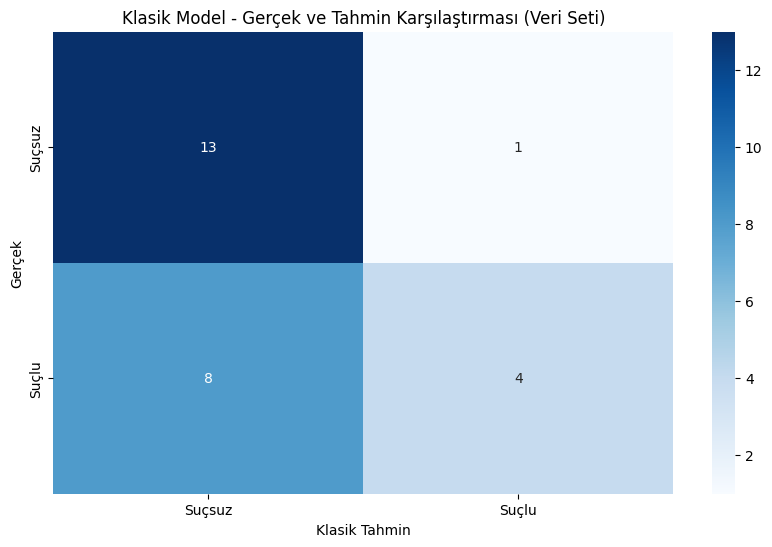

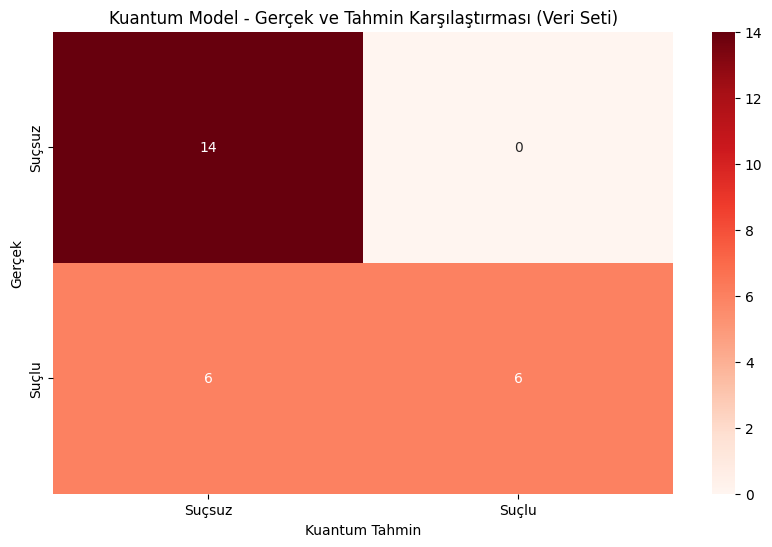

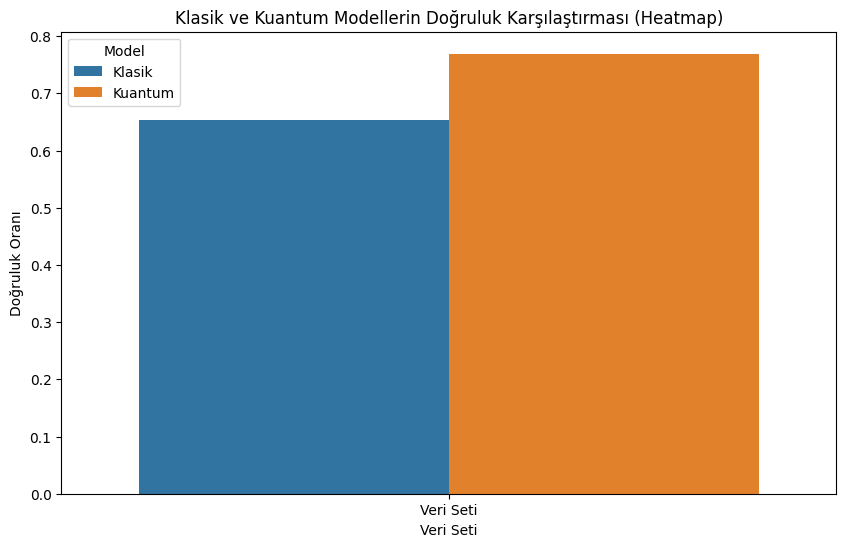

Klasik Model Doğruluğu : 65.38%
Kuantum Model Doğruluğu : 76.92%


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from qiskit import QuantumCircuit
from qiskit_aer import Aer
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit import transpile
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel

np.random.seed(42)

# Veri seti boyutu
n = 26

# Rastgele veri seti oluşturma(gerçek)
data_gercek = {
    'id': range(1, n + 1),
    'isim': [f'Kisi_{i}' for i in range(1, n + 1)],
    'soyisim': [f'Soy_{i}' for i in range(1, n + 1)],
    'vatandaslik': np.random.choice(['Turkey', 'USA', 'Germany', 'UK', 'France'], n),
    'cinsiyet': np.random.choice(['Erkek', 'Kadin'], n),
    'suc': np.random.choice(['Hırsızlık', 'Dolandırıcılık', 'Yolsuzluk', 'Kavga'], n),
    'gercek_suclu': np.random.choice([0, 1], n)
}

# Rastgele veri seti oluşturma(mahkeme)
data_mahkeme = {
    'id': range(1, n + 1),
    'isim': [f'Kisi_{i}' for i in range(1, n + 1)],
    'soyisim': [f'Soy_{i}' for i in range(1, n + 1)],
    'vatandaslik': np.random.choice(['Turkey', 'USA', 'Germany', 'UK', 'France'], n),
    'cinsiyet': np.random.choice(['Erkek', 'Kadin'], n),
    'suc': np.random.choice(['Hırsızlık', 'Dolandırıcılık', 'Yolsuzluk', 'Kavga'], n),
    'mahkeme_karari': np.random.choice([0, 1], n)  # 0: Suçsuz, 1: Suçlu
}

df_gercek = pd.DataFrame(data_gercek)
df_mahkeme = pd.DataFrame(data_mahkeme)

# Kategorik değişkenleri sayısal değerlere dönüştürme
combined_df = pd.concat([df_mahkeme, df_gercek])
combined_encoded = pd.get_dummies(combined_df, columns=['vatandaslik', 'cinsiyet', 'suc'], drop_first=True)

# DataFrame'leri ayırma
df_mahkeme_encoded = combined_encoded.iloc[:n]
df_gercek_encoded = combined_encoded.iloc[n:]

# Eksik değerleri doldurma
df_mahkeme_encoded = df_mahkeme_encoded.apply(pd.to_numeric, errors='coerce').fillna(0)
df_gercek_encoded = df_gercek_encoded.apply(pd.to_numeric, errors='coerce').fillna(0)

# Eğitim ve test veri setlerini oluşturma
X_train, X_test, y_train, y_test = train_test_split(df_mahkeme_encoded.drop(columns=['id', 'isim', 'soyisim', 'mahkeme_karari', 'gercek_suclu']), df_mahkeme_encoded['mahkeme_karari'], test_size=0.2, random_state=42)

# Verileri ölçeklendirme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Klasik lojistik regresyon modelini eğitme
classic_model = LogisticRegression()
classic_model.fit(X_train_scaled, y_train)

# Klasik model tahminleri
y_pred_train_classic = classic_model.predict(X_train_scaled)
y_pred_test_classic = classic_model.predict(X_test_scaled)

# Klasik model doğruluk hesaplama
train_accuracy_classic = accuracy_score(y_train, y_pred_train_classic)
test_accuracy_classic = accuracy_score(y_test, y_pred_test_classic)

# Kuantum kernel oluşturma
feature_dim = X_train.shape[1]
feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2)

# QSVC modelini eğitme
quantum_kernel = TrainableFidelityQuantumKernel(feature_map=feature_map)
qsvc = QSVC(quantum_kernel=quantum_kernel)
qsvc.fit(X_train_scaled, y_train)

# Kuantum model ile tahminler yapma
y_pred_train_quantum = qsvc.predict(X_train_scaled)
y_pred_test_quantum = qsvc.predict(X_test_scaled)

# Kuantum model doğruluk hesaplama
train_accuracy_quantum = accuracy_score(y_train, y_pred_train_quantum)
test_accuracy_quantum = accuracy_score(y_test, y_pred_test_quantum)

# Veri seti için tahminler yapma
y_pred_all_classic = classic_model.predict(scaler.transform(df_mahkeme_encoded.drop(columns=['id', 'isim', 'soyisim', 'mahkeme_karari', 'gercek_suclu'])))
y_pred_all_quantum = qsvc.predict(scaler.transform(df_mahkeme_encoded.drop(columns=['id', 'isim', 'soyisim', 'mahkeme_karari', 'gercek_suclu'])))

# Klasik model için karışıklık matrisi ve ısı haritası
conf_matrix_all_classic = confusion_matrix(df_mahkeme_encoded['mahkeme_karari'], y_pred_all_classic)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix_all_classic, annot=True, fmt='d', cmap='Blues', xticklabels=['Suçsuz', 'Suçlu'], yticklabels=['Suçsuz', 'Suçlu'])
plt.title('Klasik Model - Gerçek ve Tahmin Karşılaştırması (Veri Seti)')
plt.xlabel('Klasik Tahmin')
plt.ylabel('Gerçek')
plt.show()

# Kuantum model için karışıklık matrisi ve ısı haritası
conf_matrix_all_quantum = confusion_matrix(df_mahkeme_encoded['mahkeme_karari'], y_pred_all_quantum)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix_all_quantum, annot=True, fmt='d', cmap='Reds', xticklabels=['Suçsuz', 'Suçlu'], yticklabels=['Suçsuz', 'Suçlu'])
plt.title('Kuantum Model - Gerçek ve Tahmin Karşılaştırması (Veri Seti)')
plt.xlabel('Kuantum Tahmin')
plt.ylabel('Gerçek')
plt.show()
# Klasik model için karışıklık matrisi
conf_matrix_all_classic = confusion_matrix(df_mahkeme_encoded['mahkeme_karari'], y_pred_all_classic)

# Kuantum model için karışıklık matrisi
conf_matrix_all_quantum = confusion_matrix(df_mahkeme_encoded['mahkeme_karari'], y_pred_all_quantum)

# Doğruluk oranlarını hesaplama
def calculate_accuracy(conf_matrix):
    true_positives = conf_matrix[1, 1]
    true_negatives = conf_matrix[0, 0]
    total_samples = conf_matrix.sum()
    accuracy = (true_positives + true_negatives) / total_samples
    return accuracy

# Klasik model doğruluk oranı
classic_accuracy = calculate_accuracy(conf_matrix_all_classic)

# Kuantum model doğruluk oranı
quantum_accuracy = calculate_accuracy(conf_matrix_all_quantum)

# Doğruluk oranlarını bir DataFrame'e ekleme
accuracy_results_heatmap = {
    'Data': ['Veri Seti', 'Veri Seti'],
    'Accuracy': [classic_accuracy, quantum_accuracy],
    'Model': ['Klasik', 'Kuantum']
}
accuracy_df_heatmap = pd.DataFrame(accuracy_results_heatmap)

# Doğruluk oranlarını görselleştirme
plt.figure(figsize=(10, 6))
sns.barplot(x='Data', y='Accuracy', hue='Model', data=accuracy_df_heatmap)
plt.title('Klasik ve Kuantum Modellerin Doğruluk Karşılaştırması (Heatmap)')
plt.ylabel('Doğruluk Oranı')
plt.xlabel('Veri Seti')
plt.show()

print(f"Klasik Model Doğruluğu : {classic_accuracy * 100:.2f}%")
print(f"Kuantum Model Doğruluğu : {quantum_accuracy * 100:.2f}%")


# AMAÇ:
Farklı veri seti boyutları için klasik lojistik regresyon ve kuantum destek vektör makinesi (QSVC) modellerinin performansını karşılaşırmak, veri setleri rastgele oluşturmak, sayısal değerlere dönüştürmek, eksik değerleri doldurmak, veriler ölçeklendirmek ve ardından modelleri eğitmek ve test etmektedir. Sonuçlar, doğruluk oranları ve karışıklık matrisi kullanılarak görselleştirilir. Her veri seti boyutu için klasik ve kuantum modellerin doğruluk oranlarını karşılaştırır. Farklı veri seti boyutlarında modellerin performansını analiz ederek daha geniş bir perspektif sağlar. Her veri seti boyutu için doğruluk oranları hesaplanır ve sonuçlar grafik olarak görselleştirilir. İlk koda göre daha kapsamlı bir analiz sunar, çünkü farklı veri seti boyutlarının performans üzerindeki etkilerini incelemeye olanak tanır. Bu, model performansının veri seti boyutuna bağlı olarak nasıl değiştiğini anlamak için önemli bir bilgi sağlar.

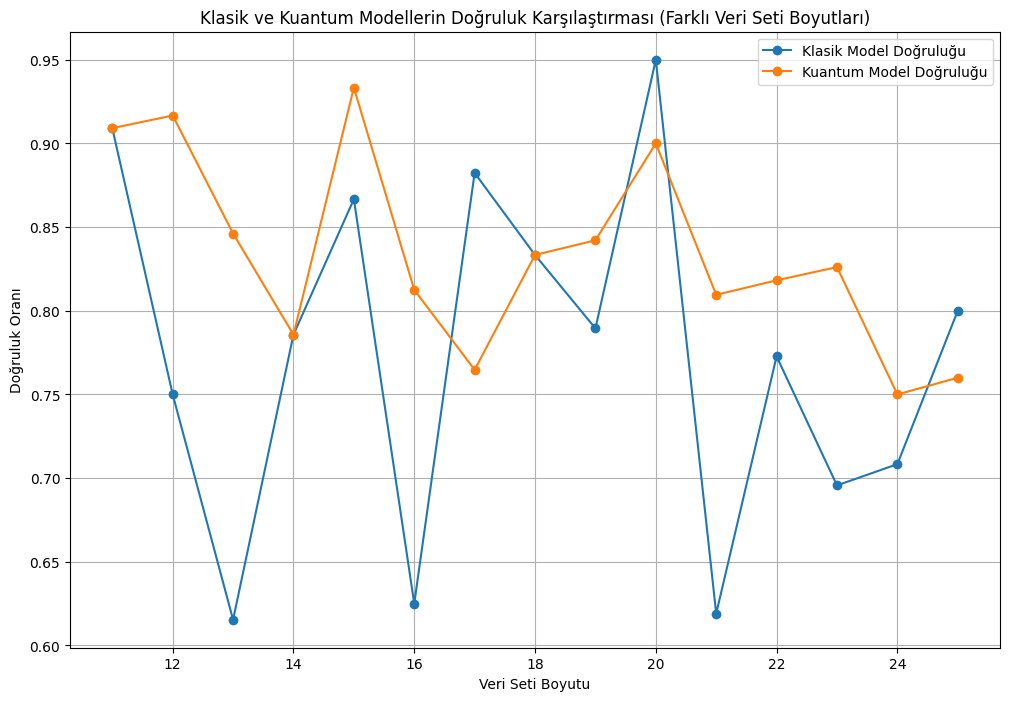

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel

np.random.seed(42)

# Veri seti boyutlarını tanımla
n_values = range(11, 26)

classic_accuracies = []
quantum_accuracies = []

def calculate_accuracy(conf_matrix):
  """Calculates accuracy from a confusion matrix."""
  return np.trace(conf_matrix) / np.sum(conf_matrix)

for n in n_values:
    # Rastgele veri seti oluşturma (gerçek)
    data_gercek = {
        'id': range(1, n + 1),
        'isim': [f'Kisi_{i}' for i in range(1, n + 1)],
        'soyisim': [f'Soy_{i}' for i in range(1, n + 1)],
        'vatandaslik': np.random.choice(['Turkey', 'USA', 'Germany', 'UK', 'France'], n),
        'cinsiyet': np.random.choice(['Erkek', 'Kadin'], n),
        'suc': np.random.choice(['Hırsızlık', 'Dolandırıcılık', 'Yolsuzluk', 'Kavga'], n),
        'gercek_suclu': np.random.choice([0, 1], n)
    }

    # Rastgele veri seti oluşturma (mahkeme)
    data_mahkeme = {
        'id': range(1, n + 1),
        'isim': [f'Kisi_{i}' for i in range(1, n + 1)],
        'soyisim': [f'Soy_{i}' for i in range(1, n + 1)],
        'vatandaslik': np.random.choice(['Turkey', 'USA', 'Germany', 'UK', 'France'], n),
        'cinsiyet': np.random.choice(['Erkek', 'Kadin'], n),
        'suc': np.random.choice(['Hırsızlık', 'Dolandırıcılık', 'Yolsuzluk', 'Kavga'], n),
        'mahkeme_karari': np.random.choice([0, 1], n)  # 0: Suçsuz, 1: Suçlu
    }

    df_gercek = pd.DataFrame(data_gercek)
    df_mahkeme = pd.DataFrame(data_mahkeme)

    # Kategorik değişkenleri sayısal değerlere dönüştürme
    combined_df = pd.concat([df_mahkeme, df_gercek])
    combined_encoded = pd.get_dummies(combined_df, columns=['vatandaslik', 'cinsiyet', 'suc'], drop_first=True)

    # DataFrame'leri ayırma
    df_mahkeme_encoded = combined_encoded.iloc[:n]
    df_gercek_encoded = combined_encoded.iloc[n:]

    # Eksik değerleri doldurma
    df_mahkeme_encoded = df_mahkeme_encoded.apply(pd.to_numeric, errors='coerce').fillna(0)
    df_gercek_encoded = df_gercek_encoded.apply(pd.to_numeric, errors='coerce').fillna(0)

    # Eğitim ve test veri setlerini oluşturma
    X_train, X_test, y_train, y_test = train_test_split(df_mahkeme_encoded.drop(columns=['id', 'isim', 'soyisim', 'mahkeme_karari', 'gercek_suclu']), df_mahkeme_encoded['mahkeme_karari'], test_size=0.2, random_state=42)

    # Verileri ölçeklendirme
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Klasik lojistik regresyon modelini eğitme
    classic_model = LogisticRegression()
    classic_model.fit(X_train_scaled, y_train)

    # Kuantum kernel oluşturma
    feature_dim = X_train.shape[1]
    feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2)

    # QSVC modelini eğitme
    quantum_kernel = TrainableFidelityQuantumKernel(feature_map=feature_map)
    qsvc = QSVC(quantum_kernel=quantum_kernel)
    qsvc.fit(X_train_scaled, y_train)

    # Veri seti için tahminler yapma
    y_pred_all_classic = classic_model.predict(scaler.transform(df_mahkeme_encoded.drop(columns=['id', 'isim', 'soyisim', 'mahkeme_karari', 'gercek_suclu'])))
    y_pred_all_quantum = qsvc.predict(scaler.transform(df_mahkeme_encoded.drop(columns=['id', 'isim', 'soyisim', 'mahkeme_karari', 'gercek_suclu'])))

    # Klasik model için karışıklık matrisi
    conf_matrix_all_classic = confusion_matrix(df_mahkeme_encoded['mahkeme_karari'], y_pred_all_classic)

    # Kuantum model için karışıklık matrisi
    conf_matrix_all_quantum = confusion_matrix(df_mahkeme_encoded['mahkeme_karari'], y_pred_all_quantum)

    # Doğruluk oranlarını hesaplama
    classic_accuracy = calculate_accuracy(conf_matrix_all_classic)
    quantum_accuracy = calculate_accuracy(conf_matrix_all_quantum)

    # Doğruluk oranlarını listelere ekleme
    classic_accuracies.append(classic_accuracy)
    quantum_accuracies.append(quantum_accuracy)

# Doğruluk oranlarını görselleştirme
plt.figure(figsize=(12, 8))
plt.plot(n_values, classic_accuracies, label='Klasik Model Doğruluğu', marker='o')
plt.plot(n_values, quantum_accuracies, label='Kuantum Model Doğruluğu', marker='o')
plt.title('Klasik ve Kuantum Modellerin Doğruluk Karşılaştırması (Farklı Veri Seti Boyutları)')
plt.xlabel('Veri Seti Boyutu')
plt.ylabel('Doğruluk Oranı')
plt.legend()
plt.grid(True)
plt.show()
